# Process
In this notebook, we will analyze the dataset and prepare it for training of Recommender systems. Code sections taken from <a href = "https://github.com/rahmanidashti/FairBook"> Fairbook </a>.

## A. Import Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import random as rd
import pandas as pd
import numpy as np
from analyze_data import read_popularity, users_and_items, user_distribution,item_distribution, calculate_popularity, calculate_group_characteristics, calculate_gini_coefficient
from plots import plot_data_distribution, plot_popularity_distribution, plot_profile_size_vs_popularity, plot_group_characteristics, plot_Lorenz
from split_users import sort_user_dist, split
import pickle as pkl
pd.set_option("display.precision", 5)

In [2]:
raw_file_location = "data/raw/" # here are stored the raw data files
processed_file_location = "data/processed/" # here we store the processed data files

## B. Set hyperparameters
There are certain hyperparameters that need to be tuned before the run. 

In [3]:
item_col = "ISBN" # the item column
user_col = "User-ID"
my_seed = 0 # random_seed
top_fraction_items = 0.2 # the limit for an item to be considered popular
top_fraction_users = 0.2# the limit for a user to be considered High Mainstriminess
split_by = "pop_fraq" # sort users by fraction of popular items (pop_fraq) 

In [4]:
rd.seed(my_seed) #seed for random functions
np.random.seed(my_seed) #seed for all numpy fuctions

## C. Read files

In [5]:
#cols = ["user", "book", "rating"] # columns in the ratings dataset
df_events = pd.read_csv("data/files_with_properties/fairbook_ratings_with_readable_properties_filtered_correct_ISBNs.csv", index_col=0,low_memory=False)
print('No. of user events (i.e. ratings): ' + str(len(df_events)))

No. of user events (i.e. ratings): 86356


In [6]:
df_events.head()

,User-ID,ISBN,Book-Rating,title,author,year,publisher,alt_title,alt_author,correct_author,...,QID,sexuality,country,language,religion,gender,ethnicity,birthyear,deathyear,label
1,276847,3551551677,10,Harry Potter und der Stein der Weisen,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Stein der Weisen,Joanne K. Rowling,Joanne K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
2,276847,3551551685,10,Harry Potter und die Kammer des Schreckens,Joanne K. Rowling,2000.0,Carlsen Verlag GmbH,Harry Potter und die Kammer des Schreckens (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
3,276847,3551551693,10,Harry Potter und der Gefangene von Azkaban,J. K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Gefangene von Askaban (Ha...,J.K. Rowling,J.K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
4,276847,3551551936,10,Harry Potter Und Der Feuerkelch,Joanne K. Rowling,1999.0,Carlsen Verlag GmbH,Harry Potter und der Feuerkelch (Harry Potter 4),J.K. Rowling,J.K. Rowling,...,Q34660,NaN,United Kingdom,English,Anglicanism,female,English people,1965.0,NaN,J. K. Rowling
5,276964,0345354621,10,The Terminal Man,Michael Crichton,1988.0,Ballantine Books,The Terminal Man,Michael Crichton,Michael Crichton,...,Q172140,NaN,United States of America,NaN,deism,male,NaN,1942.0,2008.0,Michael Crichton


## D. Preprocess data
Convert book IDs into numbers (needed for the Recommender Systems library we are going to use).


Convert book IDs into numbers.

In [7]:
mapping_dict = {} # Create a dictionary that maps each ISBN to an integer.
i=0
for ISBN in df_events[item_col].unique():
    mapping_dict[ISBN] = i
    i+=1
# Save the mapping dictionary
with open(processed_file_location + "/map_ISBN_to_int.pkl", "wb") as f:
    pkl.dump(mapping_dict, f)
df_events[item_col] = df_events[item_col].map(lambda x: mapping_dict.get(x,x)) # Map in the ratings file

Create datasets for users and items.

In [8]:
users_and_items(df_events, user_col, item_col) # print properties of the ratings set
user_dist, num_users = user_distribution(df_events, user_col, item_col, prnt = True) # create dataset for all users 
item_dist, num_items = item_distribution(df_events, user_col, item_col, prnt = True) # create dataset for all items

No. user events: 86356
No. items: 5504
No. users: 6354


Mean ISBNs per user: 13.6
Min ISBNs per user: 1
Max ISBNs per user: 153


Mean users per ISBN: 15.7
Min users per ISBN: 5
Max users per ISBN: 375




Finally, we create a dataframe of the item characteristics that contains item popularity.

In [9]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist) # turn the series into a dataframe
df_item_dist.columns = ['count']
df_item_dist['count'] /= num_users # basically the popularity of every item

In [10]:
df_item_dist.head()

,count
121,0.05902
68,0.04359
40,0.03982
413,0.03903
443,0.03730


## E. Measure diversity in data

### Gini Coefficient
Reference: https://dl.acm.org/doi/pdf/10.1145/1250910.1250939, Section 3.1

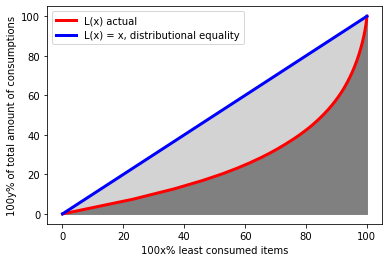

The Gini Coefficient in the data is:  0.494


In [11]:
# GINI COEFFICIENT
GC, movs, data_cdf = calculate_gini_coefficient(item_dist) # calculate gini coefficient
plot_Lorenz(movs,data_cdf, save = False, item_col=item_col) # plot lorenz curve in data
print("The Gini Coefficient in the data is: ", np.round(GC,3))

## F. Define and Calculate Popularity
An item is popular = It is among the top_fraction_items most popular items.

In [12]:
num_top = int(top_fraction_items * num_items) # choose the top_fraction_items most popular items
top_item_dist = item_dist[:num_top] #item_dist is already sorted by count, so top_item_dist is the item distribution of the "popular" items
print('No. popular items: ' + str(len(top_item_dist)))

No. popular items: 1100


In [13]:
# get pop fractions for every user
pop_count,user_hist,pop_fraq, pop_item_fraq = calculate_popularity(df_events, top_item_dist, item_dist, num_users, user_col, item_col) # calculate profile size, fraction of popular items, average popularity and number of popular items for all users.
#pop_count,user_hist,pop_fraq, pop_item_fraq = read_popularity(item_col)

## G. Plot distribution of data and popularity

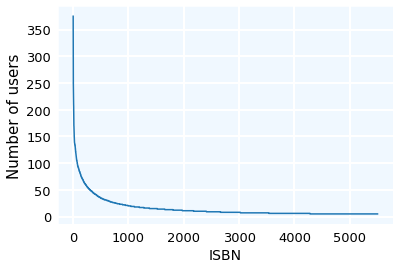

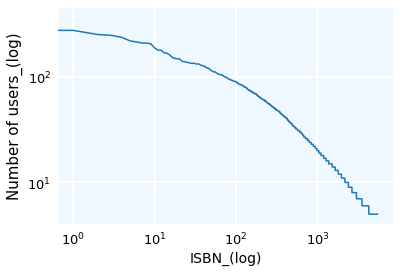

In [14]:
plot_data_distribution(item_dist, item_col, save = False) # item vs number of users
plot_data_distribution(item_dist, item_col, [False, 0],True, save = False) # item vs number of users - log scale

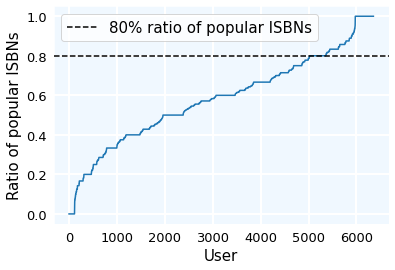

R-value: 0.929420140239003


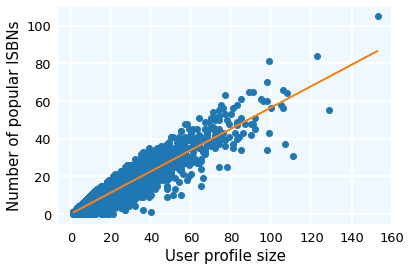

R-value: -0.030079327769241174


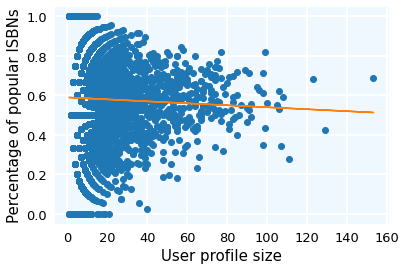

R-value: -0.04464811066022148


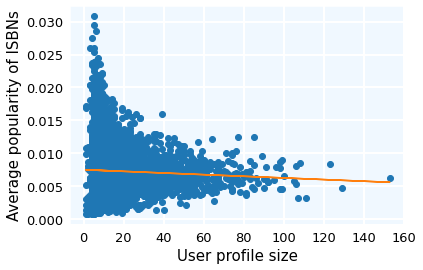

In [15]:
plot_popularity_distribution(pop_fraq, item_col, save = False) # distribution of popularity among items
plot_profile_size_vs_popularity(pop_count,user_hist, "count", item_col, save = False) # number of popular vs profile size
plot_profile_size_vs_popularity(pop_fraq,user_hist, "percentage", item_col, save = False) # fraction of popular vs profile size
plot_profile_size_vs_popularity(pop_item_fraq,user_hist, "average", item_col, save = False) #  average popularity vs profile size

## H. Divide user groups
Divide users based on a: [top_fraction_items, 100%-2*top_fraction_items, top_fraction_items] scheme. (e.g. 20%-60%-20%).

Note 1. The users are sorted based on "split_by".

Note 2. GAP is a metric for average popularity of items in a group's users' profiles.

Note 3. MS = Mainstreaminess.

In [16]:
# Divide Users based on split_by

user_dist_sorted = sort_user_dist(user_dist, pop_count, user_hist, pop_fraq, pop_item_fraq, by = split_by)
low, med, high = split(user_dist_sorted, top_fraction_items)

low_profile_size, med_profile_size, high_profile_size, low_nr_users, med_nr_users, high_nr_users, low_GAP, med_GAP, high_GAP = calculate_group_characteristics(low, med, high)
print('LowMS GAP: ' + str(low_GAP))
print('MedMS GAP: ' + str(med_GAP))
print('HighMS GAP: ' + str(high_GAP))

LowMS GAP: 0.0036837892288499306
MedMS GAP: 0.007299996356588213
HighMS GAP: 0.011080921825186508


## I. Plot group characteristics
Plot popularity distribution among user groups.

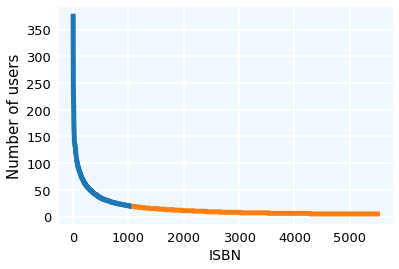

The blue items are the 'popular' ones.


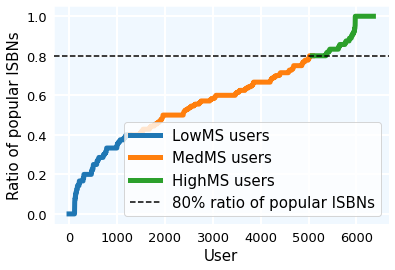

In [17]:
plot_data_distribution(item_dist, item_col, dividing = [True, top_fraction_items], log = False, save = False)
print("The blue items are the 'popular' ones.")
plot_popularity_distribution(pop_fraq, item_col, dividing = [True,top_fraction_items], save = False)

LowMS: 1270
MedMS: 3813
HighMS: 1271


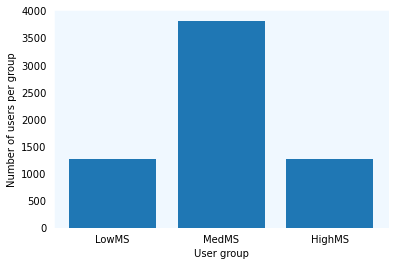

LowMS: 11.299212598425196
MedMS: 15.873852609493836
HighMS: 9.03147128245476


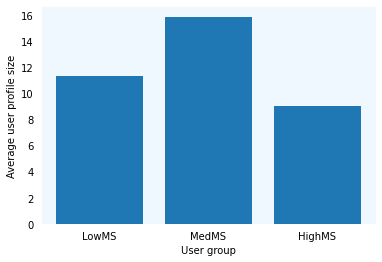

In [18]:
plot_group_characteristics(low_nr_users, med_nr_users, high_nr_users, way = "number of users", item_col = item_col, save = False)
plot_group_characteristics(low_profile_size, med_profile_size, high_profile_size, way = "size", item_col = item_col, save = False)

## J. Save Processed Data
Now we will save all the files that are needed for training the Recommender Systems and analyzing the results.
1. The processed ratings file df_events
2. The LowMS, MedMS and HighMS users.
3. The item popularity dataframe df_item_dist.
4. The GAP of LowMS, MedMS & HighMS.

(We have already saved the "mapped" files.

In [19]:
df_events.to_csv(processed_file_location  +"/fairbook_ratings_mapped.csv", index=False)

In [20]:
low.to_csv(processed_file_location  +"/low_users.csv")
med.to_csv(processed_file_location + "/med_users.csv")
high.to_csv(processed_file_location + "/high_users.csv")

In [21]:
df_item_dist.to_csv(processed_file_location + "/item_pop_dist.csv")

In [22]:
GAP_list = [low_GAP, med_GAP, high_GAP]
with open(processed_file_location+"/GAP_list.pkl", "wb") as f:
    pkl.dump(GAP_list, f)